# Example k3d in discretisedfield

In [1]:
import k3d
import pylab
import matplotlib
import numpy as np
import discretisedfield as df
import matplotlib.pyplot as plt
%matplotlib inline

/Users/sergii.mamedov/Documents/joommf/discretisedfield/discretisedfield/__init__.py:4: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use("agg")


## Simple sample

Create a 10 x 10 x 10 nm sample. The initial field is directed along the X axis, in a volume bounded by a sphere with a diameter of 5 nm.

In [2]:
size = 10
sphere = 10
mesh = df.Mesh(p1=(-size, -size, -size), p2=(size, size, size), cell=(1, 1, 1))

def val(pos):
    x, y, z = pos
    return x*1.5, x, 0#y, x, x*y

def norm_fun(pos):
    x, y, z = pos
    #if x**2 + y**2 + z**2 < sphere**2:
    if x**2 + y**2 < sphere**2:
        return 1
    else:
        return 0

field = df.Field(mesh, value=val, norm=norm_fun)

## Vector field

We need create of vector field from `field.array`. We exclude all zero length vectors in our case.

Get the values of vectors from the field and select only non-zero vectors

In [3]:
field_ = field.array.copy()
vectors = field_.reshape(-1,3)
vectors_nonzero = vectors[np.sum(vectors**2,axis=-1) !=0]

Get the vector start coordinates and select only non-zero vectors

In [4]:
origins = np.array(list(field.mesh.coordinates))
origins_nonzero = origins[np.sum(vectors**2,axis=-1) !=0]

Shift non-zero vector start coordinate to the center of cell

In [5]:
origins_nonzero -= 0.5 * vectors_nonzero

### Same color
Plotting vector field with single color for all vectors. Decrease value of all vectors for vector_scale constant.

In [6]:
color = 0xff
vector_scale = 1.0

plot = k3d.plot()
plt  = k3d.vectors(origins_nonzero, vector_scale*vectors_nonzero, color=color)
plt_centers = k3d.points(np.array(list(field.mesh.coordinates)))
plt_centers.point_size = 0.1
plt_centers.color = 0x00ff00
plot += plt_centers
plot += plt
plot.display()

/Users/sergii.mamedov/miniconda3/envs/joommf2/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

### Different colors
If we want to use different colors for the vectors, we use the color set from the package **pylab** (`pylab.cm.get_cmap()`). 

In [7]:
# return a list of tuple (r, g, b) color coordinate
def _get_colormap(name, n):
    data = []
    cmap = pylab.cm.get_cmap(name, n)
    for i in range(cmap.N):
        rgb = cmap(i)[:3]
        data.append(rgb)

    return np.array(data)

We find the minimum and maximum value of the projection of the vector on the selected axis (`direction={0, 1, 2}`) and divide this range into 256. Thus, for each vector we set one of the colors from the colormap.
If it is constant field - using middle value of colormap.

In [8]:
direction = 0

projection = vectors_nonzero[:, direction]
if projection.max() - projection.min() > 0.0:
    projection = list((projection + abs(projection.min())) / (projection.max() - projection.min()) * 255)
else:
    projection = [128 for i in vectors_nonzero] # constant field
projection = [int(i) for i in projection]

Divide values of vectors and colormap set into 256 bins, and match each vector with a specific color.

In [9]:
colormap_name = 'viridis'

bins = np.array([i for i in range(256)])
colormap = _get_colormap(colormap_name, 256)

projection = colormap[np.digitize(projection, bins, right=True)]
colors = ['0x{}'.format(matplotlib.colors.rgb2hex(rgb)[1:]) for rgb in projection]
colors = [(int(i, 16), int(i, 16)) for i in colors]

Plotting vector field. Decrease value of all vectors for vector_scale constant.

In [10]:
plot = k3d.plot()
plt  = k3d.vectors(origins_nonzero, vector_scale*vectors_nonzero, colors=colors)
plot += plt
plot.display()

Output()

**Question**:

* How add the legend?

# Scalor filed

Create a 10 x 10 x 10 nm sample. The initial field is directed along the X axis, in a volume bounded by a sphere with a diameter of 5 nm.

In [11]:
size = 5
mesh = df.Mesh(p1=(-size, -size, -size), p2=(size, size, size), cell=(1, 1, 1))

def val(pos):
    x, y, z = pos
    return y*x

field_scalor = df.Field(mesh, value=val, dim=1)

Plotting scalor field. Using existed colormap set.

In [12]:
plot = k3d.plot()
plt  = k3d.volume(field_scalor.array, bounds=[-size, size, -size, size, -size, size],
                  color_map=np.array(k3d.basic_color_maps.Jet, dtype=np.float32),
                 )
plot += plt
plot.display()

Output()

**Question:**
* How add the legend?
* How disable interpolation (example below)?

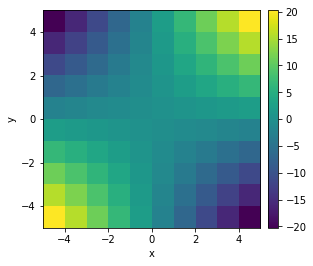

In [13]:
field_scalor.plot_plane("z")

# Slice vector field

Visualization of a vector field on a selected plane. Using the function `field.mesh.plane (axis = value)` we get the coordinate values of the origin of the vectors and their magnitude. In the process, we filter those vectors whose length is equal to zero.

We obtain the coordinates of the origin of the vectors and their length on the selected plane.

In [14]:
origins_nonzero_slice = []
vectors_nonzero_slice = []
for i in list(field.mesh.plane(x=0.0)):
    vector = field(i)
    value = vector[0]**2 + vector[1]**2 + vector[2]**2
    if value > 0:
        origins_nonzero_slice.append(i)
        vectors_nonzero_slice.append(field(i))

Convert to numpy array

In [15]:
origins_nonzero_slice = np.array(origins_nonzero_slice)
vectors_nonzero_slice = np.array(vectors_nonzero_slice)
origins_nonzero_slice -= 0.5 * vectors_nonzero_slice

Plot

In [16]:
color = 0xff
vector_scale = 1.0

plot = k3d.plot()
plt  = k3d.vectors(origins_nonzero_slice, vector_scale*vectors_nonzero_slice, color=color)
plot += plt
plot.display()

Output()

# Slice scalor field

Select the field values on the plane

In [17]:
ith = 0
value_slice = field.array[:,:,ith,1]
nz,ny,nx,_  = field.array.shape

Create a list of triples of node numbers

In [18]:
ni,nj = value_slice.shape
indices = []
for i in range(ni-1):
    for j in range(nj-1):
        indices.append((i*nj+j, i*nj+j+1, (i+1)*nj+j))        # lower-left triangle
        indices.append(((i+1)*nj+j+1, i*nj+j+1, (i+1)*nj+j))  # upper-right triangle

Select the mesh coordinate

In [19]:
origins = np.array(list(field.mesh.coordinates))
origins_slice = origins.reshape(nz,ny,nx,3)[:,:,ith,:]

Plot

In [20]:
plot = k3d.plot()
plt_mesh = k3d.mesh(origins_slice, indices, attribute=value_slice,
                    color_map=k3d.basic_color_maps.CoolWarm,
                    color_range=[-1.0, 1.0])
plot += plt_mesh
plot.display()

Output()

# Overlap vector and scalor fields

## 3D

In [21]:
plot = k3d.plot()
plt_scalor  = k3d.volume(field_scalor.array, bounds=[-size, size, -size, size, -size, size],
                         color_map=np.array(k3d.basic_color_maps.Jet, dtype=np.float32))
plt_vector  = k3d.vectors(origins_nonzero, vector_scale*vectors_nonzero, colors=colors)
plot += plt_scalor
plot += plt_vector
plot.display()

Output()

## Slice

In [22]:
color = 0xff
vector_scale = 1.0

plot = k3d.plot()
plt_vector_slice = k3d.vectors(origins_nonzero_slice, vector_scale*vectors_nonzero_slice, color=color)
plt_scalor_slice = k3d.mesh(origins_slice, indices, attribute=value_slice,
                    color_map=k3d.basic_color_maps.CoolWarm,
                    color_range=[-1.0, 1.0], antialias=True)
plot += plt_mesh
plot += plt
plot.display()

Output()

# Mesh as vox

In [23]:
xmin,ymin,zmin = field.mesh.pmin
xmax,ymax,zmax = field.mesh.pmax

plot = k3d.plot()
plt_vox = k3d.voxels(field.array[...,0]!=0, color_map=[0x00ff00],
                               xmin=xmin,xmax=xmax,
                               ymin=ymin,ymax=ymax,
                               zmin=zmin,zmax=zmax)
plot += plt_vox
plot.display()

/Users/sergii.mamedov/miniconda3/envs/joommf2/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "bool" does not match required type "uint8". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

# Isosurface

In [24]:
xmin,ymin,zmin = field.mesh.pmin
xmax,ymax,zmax = field.mesh.pmax

plot = k3d.plot()
plt_iso = k3d.marching_cubes(np.sum(field.array**2,axis=-1), level=1.0,
                               xmin=xmin,xmax=xmax,
                               ymin=ymin,ymax=ymax,
                               zmin=zmin,zmax=zmax)

plot += plt_iso
plot.display()

Output()

In [25]:
xmin,ymin,zmin = field.mesh.pmin
xmax,ymax,zmax = field.mesh.pmax

plot = k3d.plot()
plt_iso = k3d.marching_cubes(np.sum(field.array**2,axis=-1), level=0.01,
                               xmin=xmin,xmax=xmax,
                               ymin=ymin,ymax=ymax,
                               zmin=zmin,zmax=zmax)

plot += plt_iso
plt_iso = k3d.marching_cubes(np.sum(field.array**2,axis=-1), level=1.0,
                               xmin=xmin,xmax=xmax,
                               ymin=ymin,ymax=ymax,
                               zmin=zmin,zmax=zmax)

plot += plt_iso
plot.display()

Output()